In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from scipy.stats import norm
from sklearn.datasets import load_breast_cancer, load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
class NaiveBayesModel(object):
    def __init__(self, classes, features, x_data, y_data, discrete_features = []):
        self.classes = classes
        self.features = features
        self.x = x_data
        self.y = y_data
        self.discrete_features = discrete_features
        self.generate_features_values()
        self.separate_by_class()
    
    def load_parameters(self):
        guide_params = guide(None)
        self.parameters = {}
        for c in self.classes:
            self.parameters[c] = {}
            for f in self.features:
                self.parameters[c][f] = guide_params[f'{c}_{f}'.replace(' ', '_')]
    
    def separate_by_class(self):
        self.separated = {}
        for i in range(len(self.x)):
            vector = self.x[i]
            label = self.classes[self.y[i]]
            if (label not in self.separated):
                self.separated[label] = []
            self.separated[label].append(vector)
        for label in self.classes:
            self.separated[label] = np.array(self.separated[label])
    
    def generate_features_values(self):
        self.features_values = {}
        for i, f in enumerate(self.features):
            if f in self.discrete_features:
                values = self.x[:,i]
                self.features_values[f] = np.unique(values)
    
    def get_data_tuples(self):
        tuples = []
        for c in self.classes:
            for i, f in enumerate(self.features):
                data = self.separated[c][:,i]
                discrete = f in self.discrete_features
                values = []
                if discrete:
                    values = self.features_values[f]
                tuples.append((f'{c}_{f}'.replace(' ', '_'), data, discrete, values))
        return tuples
    
    def predict(self, x):
        return [self._predict(r) for r in x]
    
    def _predict(self, x):
        probabilities = [1.0 for _ in self.classes]
        for i, c in enumerate(self.classes):
            for j, f in enumerate(self.features):
                if f in self.discrete_features:
                    probs = self.parameters[c][f]
                    probabilities[i] *= probs[int(x[j])]
                else:
                    loc = self.parameters[c][f][0]
                    scale = self.parameters[c][f][1]
                    probabilities[i] *= norm.pdf(x[j], loc, scale)
        return self.classes[np.argmax(probabilities)]
    
    def plot_probabilities(self):
        for i, f in enumerate(self.features):
            print(f)
            fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, dpi=100, figsize=(12,3))
            ax = axs[0]
            sns.distplot(self.x[:,i], ax=ax)
            ax.set_title('Data distribution')
            ax = axs[1]
            for c in self.classes:
                sns.kdeplot(self.separated[c][:,i], label=c, ax=ax)
            ax.set_title('Original per class distributions')
            ax.legend()
            ax = axs[2]
            left, right = axs[0].get_xlim()
            
            if f in self.discrete_features:
                x = self.features_values[f]
                for c in self.classes:
                    probs = self.parameters[c][f].detach().numpy()
                    sns.lineplot(x, probs, label=c, ax=ax)
                ax.set_title('1 Model inferred distributions')
                ax.legend()
                ax = axs[3]
                left, right = axs[0].get_xlim()
                colors = sns.color_palette("hls",len(self.classes))
                for _ in range(20):
                    self.load_parameters()
                    for j, c in enumerate(self.classes):
                        probs = self.parameters[c][f].detach().numpy()
                        sns.lineplot(x, probs, color=colors[j], ax=ax, alpha=0.5)
                ax.set_title('20 Models inferred distributions')
            else:
                x = np.linspace(left, right, 1000)
                for c in self.classes:
                    loc = self.parameters[c][f][0]
                    scale = self.parameters[c][f][1]
                    sns.lineplot(x, norm.pdf(x, loc=loc, scale=scale), label=c, ax=ax)
                ax.set_title('1 Model inferred distributions')
                ax.legend()
                ax = axs[3]
                left, right = axs[0].get_xlim()
                x = np.linspace(left, right ,1000)
                colors = sns.color_palette("hls",len(self.classes))
                for _ in range(20):
                    self.load_parameters()
                    for j, c in enumerate(self.classes):
                        loc = self.parameters[c][f][0]
                        scale = self.parameters[c][f][1]
                        sns.lineplot(x, norm.pdf(x, loc=loc, scale=scale), color=colors[j], ax=ax, alpha=0.5)
                ax.set_title('20 Models inferred distributions')
            fig.tight_layout()
            plt.show()

In [4]:
def model(x_data):
    for t in global_model.get_data_tuples():
        if t[2]:
            size = len(t[3])
            with pyro.plate(t[0], len(t[1])):
                pyro.sample(f"obs_{t[0]}", dist.Categorical(torch.ones(size) / size), obs=torch.tensor(t[1]))
        else:
            loc = pyro.sample(f"{t[0]}_loc", dist.Normal(torch.tensor(np.mean(t[1])), torch.tensor(5.)))
            scale = pyro.sample(f"{t[0]}_scale", dist.Normal(torch.tensor(np.std(t[1])), torch.tensor(1.)))
            with pyro.plate(t[0], len(t[1])):
                pyro.sample(f"obs_{t[0]}", dist.Normal(loc, torch.abs(scale)), obs=torch.tensor(t[1]))

def guide(x_data):
    params = {}
    for t in global_model.get_data_tuples():
        if t[2]:
            size = len(t[3])
            p = pyro.param(f'{t[0]}_prob_high', torch.ones(size) / size, constraint=constraints.positive)
            pyro.sample(f"obs_{t[0]}", dist.Categorical(p), infer={'is_auxiliary': True})
            params[t[0]] = p
        else:
            l_l = pyro.param(f'{t[0]}_loc_l', torch.tensor(np.mean(t[1])), constraint=constraints.positive)
            l_s = pyro.param(f'{t[0]}_loc_s', torch.tensor(5.), constraint=constraints.positive)

            s_l = pyro.param(f'{t[0]}_scale_l', torch.tensor(np.std(t[1])), constraint=constraints.positive)
            s_s = pyro.param(f'{t[0]}_scale_s', torch.tensor(1.), constraint=constraints.positive)

            loc = pyro.sample(f"{t[0]}_loc", dist.Normal(l_l, l_s))
            scale = pyro.sample(f"{t[0]}_scale", dist.Normal(s_l, s_s))
            params[t[0]] = (loc.detach().numpy(), torch.abs(scale).detach().numpy())
    return params

In [5]:
def test_dataset(dataset_function):
    ### LOAD DATA ###
    data = dataset_function()
    x = data.data
    y = data.target
    y_names = data.target_names
    feature_names = data.feature_names
    for i in range(len(feature_names)):
        x[:,i] /= x[:,i].max()
        x[:,i] *= 100
    discretize = list(range(x.shape[1] // 2))
    features = [feature_names[i] for i in discretize]
#     print(features)
    for d in discretize:
        est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
        est.fit(x[:,d].reshape(-1, 1)) 
#         print("b", x[:,d])
        x[:,d] = est.transform(x[:,d].reshape(-1, 1)).reshape(x.shape[0])
#         print("a", x[:,d])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    
    ### GENERATE MODEL ###
    global global_model
    global_model = NaiveBayesModel(y_names, feature_names, x_train, y_train, features)
    
    ### SVI ###
    num_steps = 500
    adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    
    optim = pyro.optim.Adam(adam_params)
    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=optim,
                         loss=pyro.infer.Trace_ELBO(), num_samples=len(data))
    pyro.clear_param_store()
    
    losses = []
    
    t=tqdm(range(num_steps))
    for j in t:
        loss = svi.step(data)
        losses.append(loss)
        t.set_postfix(loss=loss)
        
    global_model.load_parameters()
    
    ### RESULTS ###
    plt.plot(losses)
    plt.title("evidence lower bound (ELBO)")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.yscale("log", nonposy='clip')
    plt.show()
    
    global_model.plot_probabilities()
    
    ### ACCURACY ###
    original = [y_names[y] for y in y_test]
    scores = []
    for _ in range(50):
        global_model.load_parameters()
        predicted = global_model.predict(x_test)
        scores.append(sum([o == p for o, p in zip(original, predicted)]) / len(original))
    print("ACC MEAN:", np.mean(scores))
    print("ACC STD:", np.std(scores))

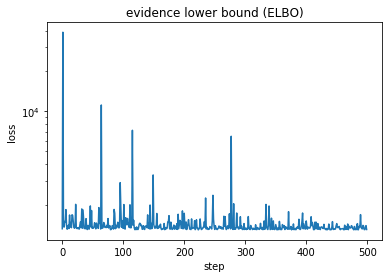

sepal length (cm)


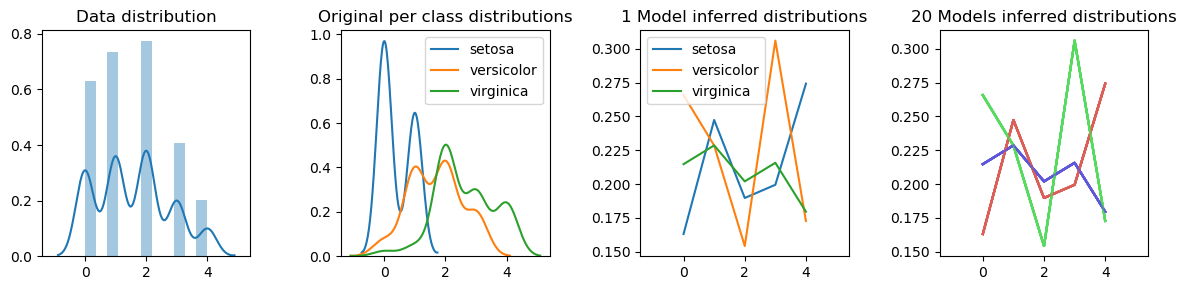

sepal width (cm)


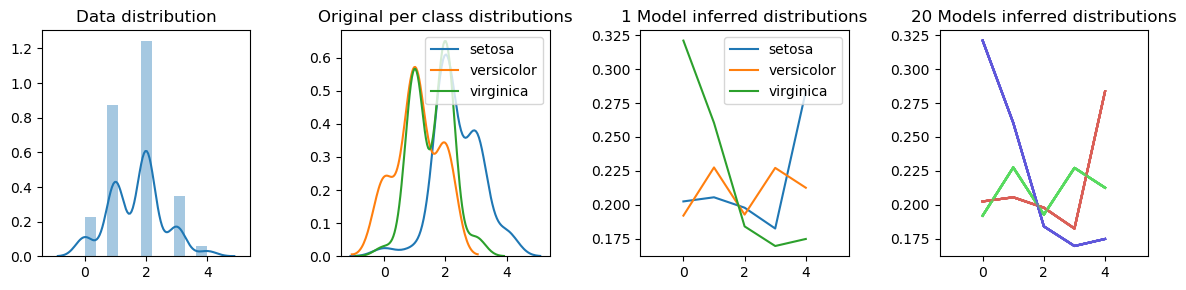

petal length (cm)


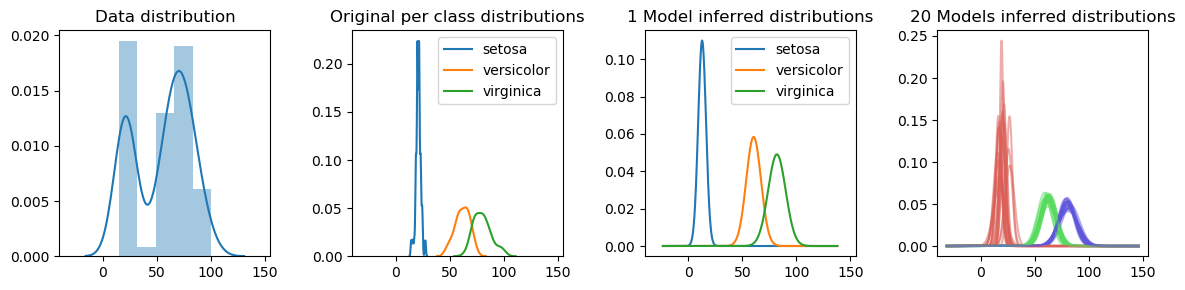

petal width (cm)


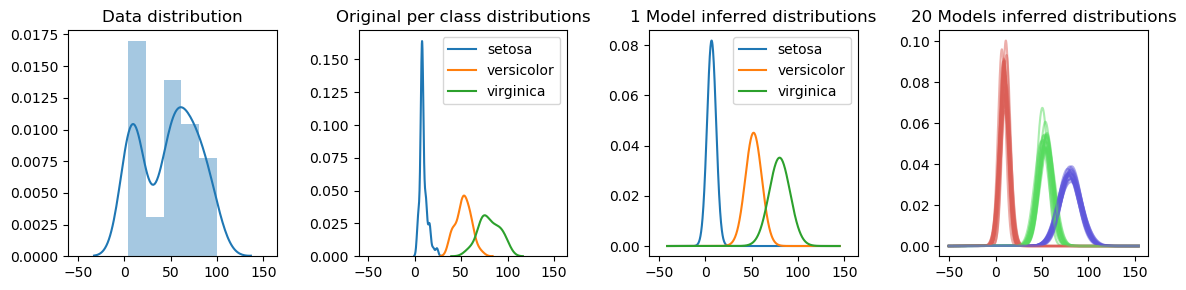

ACC MEAN: 0.997333333333
ACC STD: 0.0186666666667


In [6]:
test_dataset(load_iris)

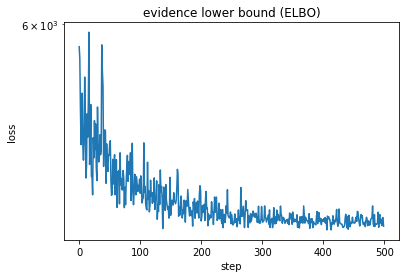

alcohol


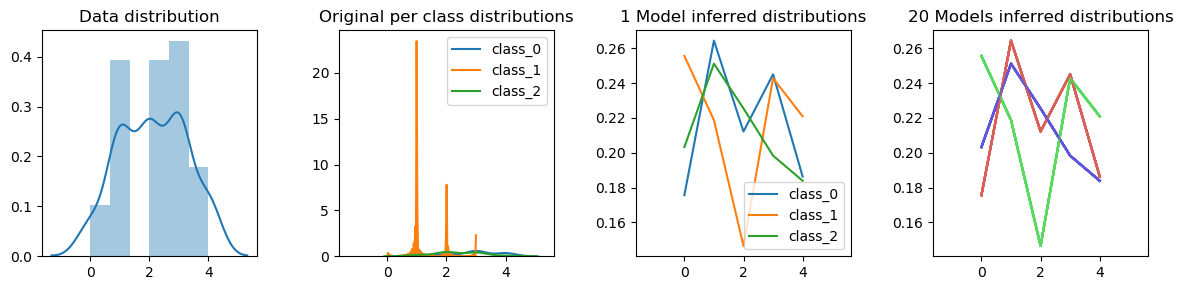

malic_acid


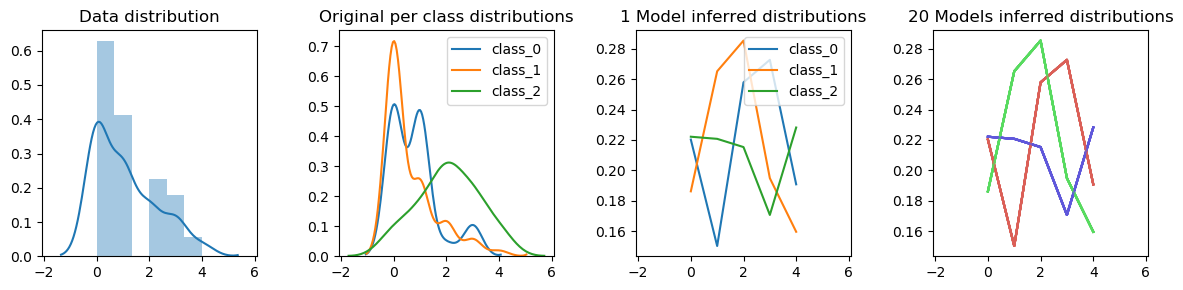

ash


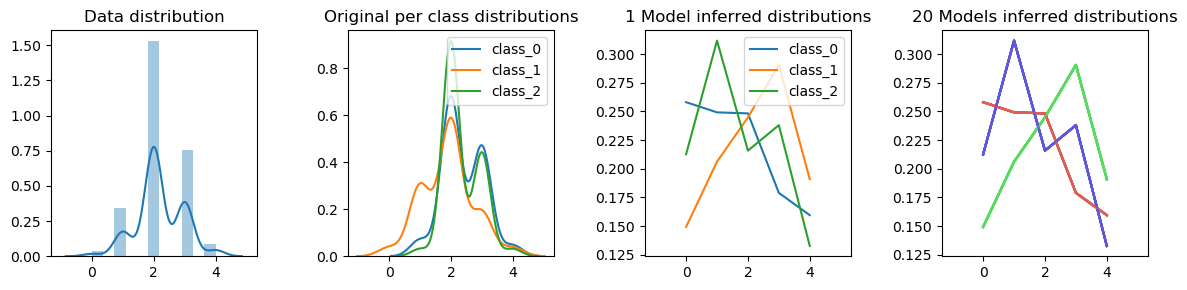

alcalinity_of_ash


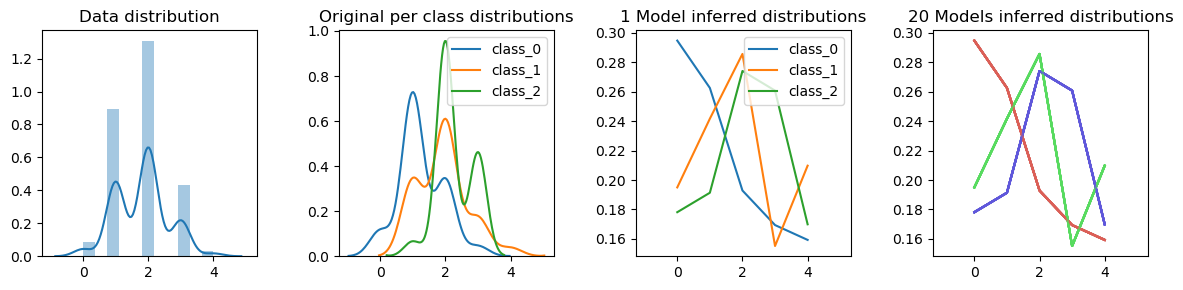

magnesium


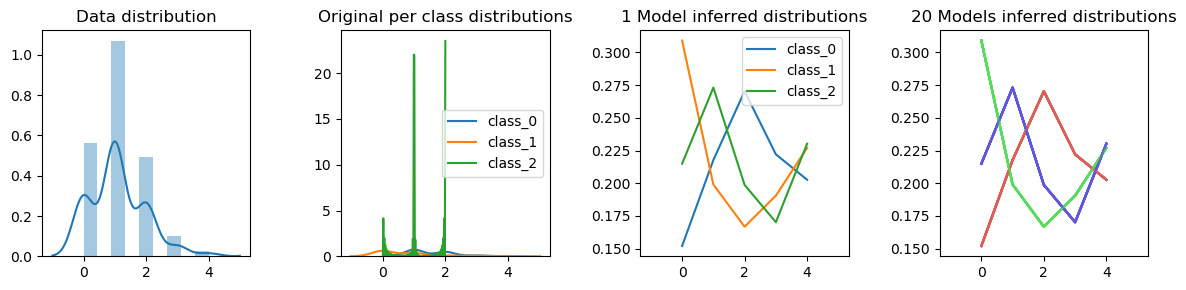

total_phenols


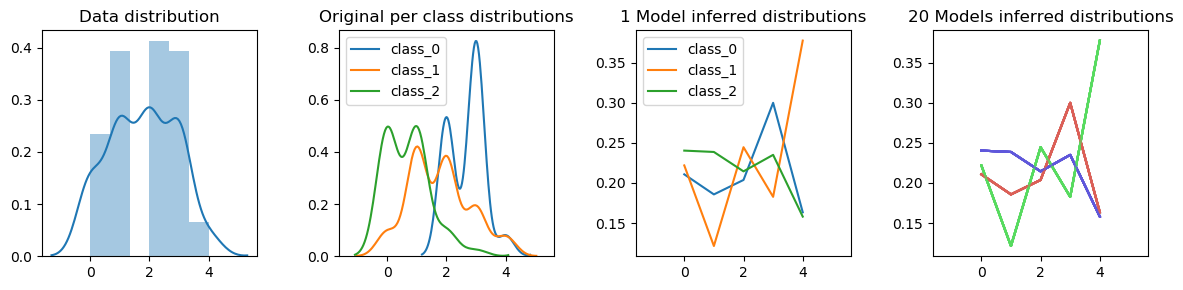

flavanoids


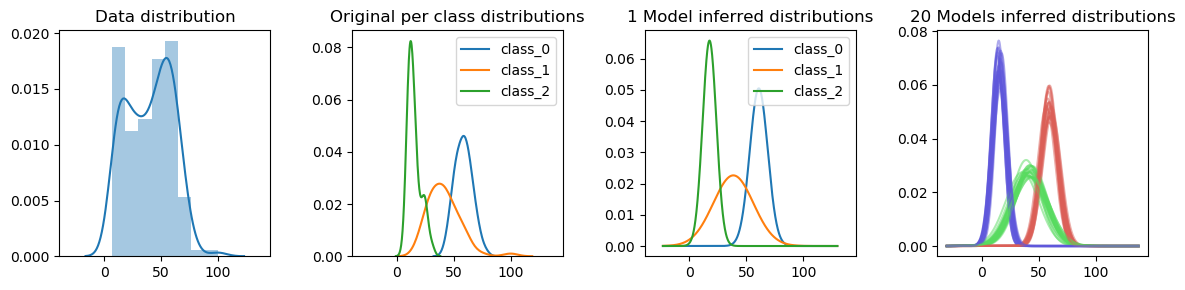

nonflavanoid_phenols


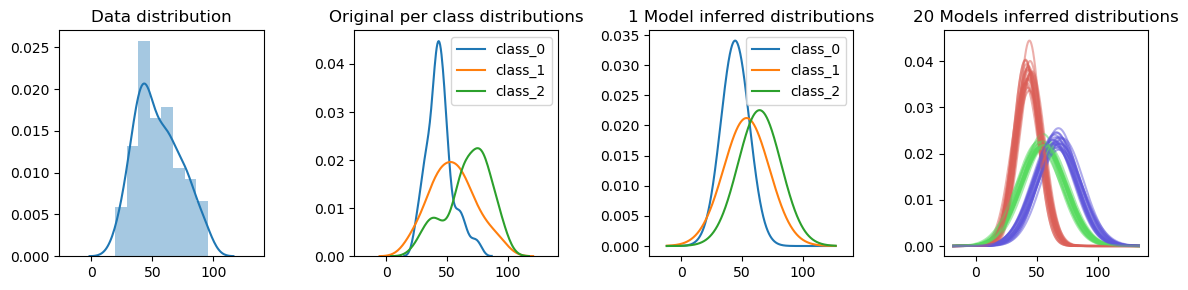

proanthocyanins


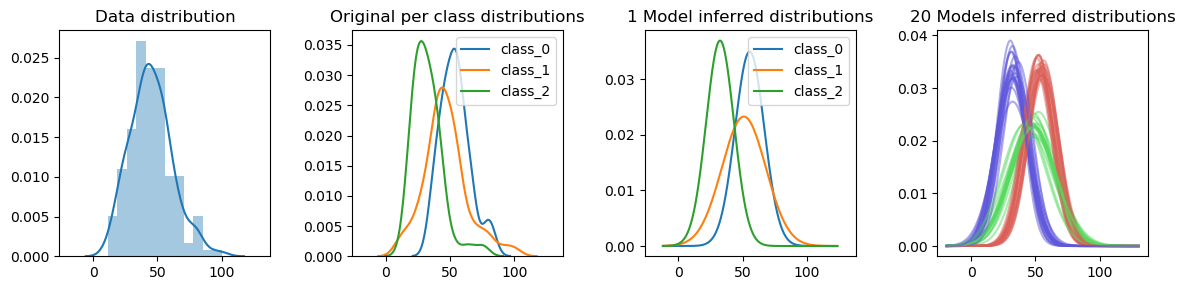

color_intensity


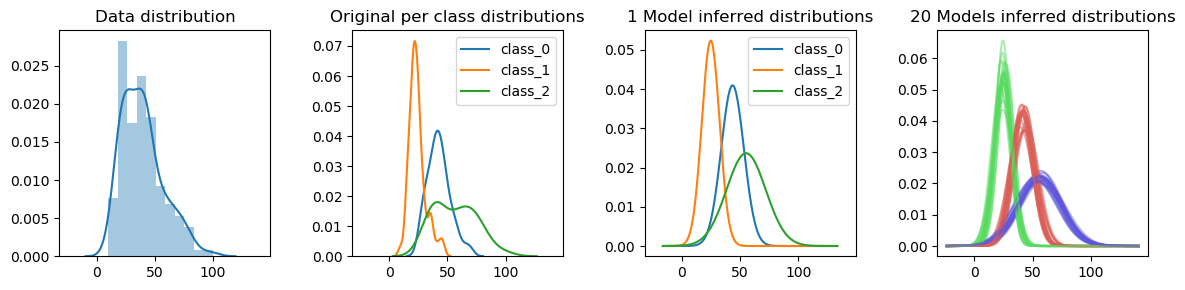

hue


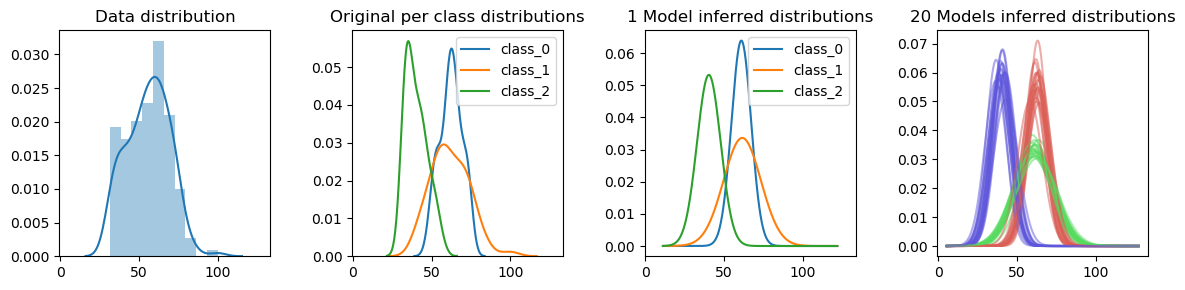

od280/od315_of_diluted_wines


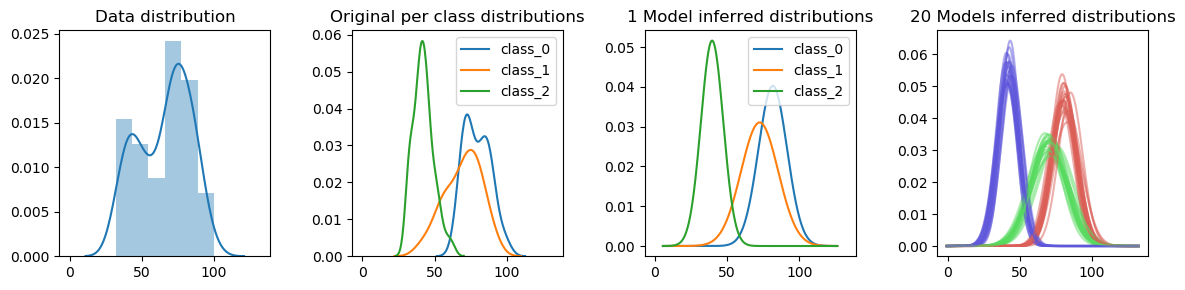

proline


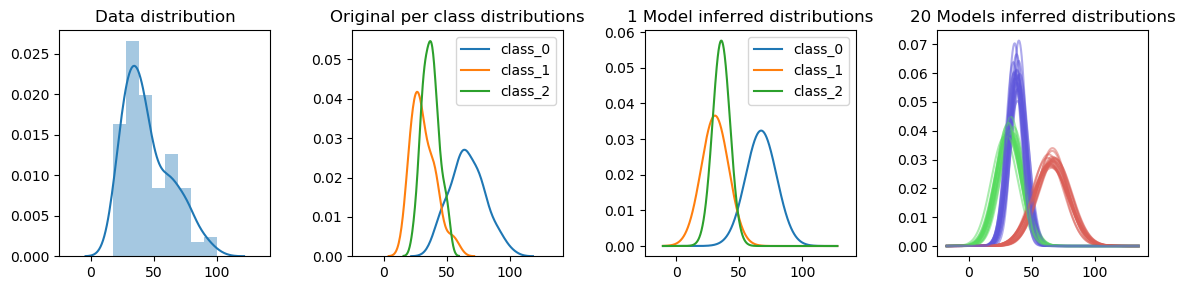

ACC MEAN: 0.993333333333
ACC STD: 0.018053418677


In [7]:
test_dataset(load_wine)

In [8]:
test_dataset(load_breast_cancer)

ValueError: Error while computing log_prob at site 'obs_malignant_radius_error':
The value argument must be within the support
                            Trace Shapes:      
                             Param Sites:      
                            Sample Sites:      
           obs_malignant_mean_radius dist 185 |
                                    value 185 |
                                 log_prob 185 |
          obs_malignant_mean_texture dist 185 |
                                    value 185 |
                                 log_prob 185 |
        obs_malignant_mean_perimeter dist 185 |
                                    value 185 |
                                 log_prob 185 |
             obs_malignant_mean_area dist 185 |
                                    value 185 |
                                 log_prob 185 |
       obs_malignant_mean_smoothness dist 185 |
                                    value 185 |
                                 log_prob 185 |
      obs_malignant_mean_compactness dist 185 |
                                    value 185 |
                                 log_prob 185 |
        obs_malignant_mean_concavity dist 185 |
                                    value 185 |
                                 log_prob 185 |
   obs_malignant_mean_concave_points dist 185 |
                                    value 185 |
                                 log_prob 185 |
         obs_malignant_mean_symmetry dist 185 |
                                    value 185 |
                                 log_prob 185 |
obs_malignant_mean_fractal_dimension dist 185 |
                                    value 185 |
                                 log_prob 185 |
          obs_malignant_radius_error dist 185 |
                                    value 185 |

In [ ]:
def test_gnb(dataset_function):
    ### LOAD DATA ###
    data = dataset_function()
    x = data.data
    y = data.target
    y_names = data.target_names
    feature_names = data.feature_names
    for i in range(len(feature_names)):
        x[:,i] /= x[:,i].max()
        x[:,i] *= 100
        
    scores = []
    for _ in range(50):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

        gnb = GaussianNB()
        gnb.fit(x_train, y_train)
        scores.append(gnb.score(x_test, y_test))
    print(np.mean(scores))

In [ ]:
# written: 0.950666666667
test_gnb(load_iris)

In [ ]:
# written: 0.994444444444
test_gnb(load_wine)

In [ ]:
# written: 0.905614035088
test_gnb(load_breast_cancer)